In [1]:
import torch, torchvision
from torch import nn
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

print(f" torch version :{torch.__version__}")
print(f" torchvision version : {torchvision.__version__}")

/Users/amittomar/miniconda3/envs/denv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


 torch version :1.13.1
 torchvision version : 0.14.1


## Load data and load train and test dataloader

In [2]:
train_data = datasets.FashionMNIST(root="data",
                                  train=True,
                                  download=True,
                                  transform=torchvision.transforms.ToTensor(), # How do we transform the data
                                  target_transform=None)  # How do you transofrm the labels

test_data = datasets.FashionMNIST(root="data",
                                  train=False,
                                  download=True,
                                  transform=torchvision.transforms.ToTensor(), # How do we transform the data
                                  target_transform=None)  # How do you transofrm the labels


In [3]:
len(train_data), len(test_data)

(60000, 10000)

In [4]:
# setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [5]:
class_names = train_data.class_to_idx
id_to_class = {}
for idx,clas in enumerate(class_names):
    id_to_class[idx]= clas
id_to_class


{0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'}

In [6]:
#prepare Dataloader
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
# not shuffling the test data
test_dataloader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False )
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x11bde6e00>,
 <torch.utils.data.dataloader.DataLoader at 0x11bde7370>)

## Create Model with linear and Non Liner layer

In [7]:
class FashionMnistModelV1(nn.Module):
    def __init__(self,
                input_shape: int,
                hidden_unit: int,
                output_shape:int):
        super().__init__()
        self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape, out_features=hidden_unit),
        nn.ReLU(),
        nn.Linear(in_features=hidden_unit,
                 out_features= output_shape),
        nn.ReLU())
    
    def forward(self, x):
        return self.layer_stack(x)

In [8]:
# create manual instance pf MOdel_1
torch.manual_seed(42)
model_1 = FashionMnistModelV1(input_shape=784,
                             hidden_unit=10,
                             output_shape=len(class_names)).to(device)

In [9]:
model_1.parameters()

<generator object Module.parameters at 0x11bd83530>

## Set loss fun and Optimizer

In [10]:
from helper_functions import accuracy_fn
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),lr=0.001)

## Functioning Training and testing Step in shape of different reusable functions

In [11]:
torch.manual_seed(42)
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn : torch.nn.Module,
              accuracy_fn,
             device: torch.device = device) :
    """ Returns a dictionary containing the results of model predicting on data loader"""
    loss, acc = 0,0
    model.eval()
    with torch.inference_mode():
        for X,y in tqdm(data_loader):
            X,y = X.to(device), y.to(device)
            # Make ored
            y_pred = model(X)
            
            # Acumulate teh loss and accuracy
            
            loss += loss_fn(y_pred,y)
            acc += accuracy_fn(y_true =y, y_pred=y_pred.argmax(dim=1))
        
        # normalize loss and acc by getting mean of batch for loss/acc
        loss /= len(data_loader)
        acc /= len(data_loader)
    print(f"Test loss: {loss:3f} | Test acc : {acc:2f}% \n")
    return{ "model_name" : model.__class__.__name__,
               "model_loss" : loss.item(),
               "model_acc" : acc
        }

In [12]:
#@title Default title text
def train_step(model : torch.nn.Module,
               dataloader : torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    """Performs a training with model trying to learn on dataloader"""
    train_loss, train_acc = 0,0
    for batch, (X,y) in enumerate(dataloader):
        X,y = X.to(device), y.to(device)
        model.train()
        #1, Fwd pass
        y_pred = model(X)
        #2. loss
        loss = loss_fn(y_pred,y)
        train_loss += loss

        train_acc += accuracy_fn(y_true=y,y_pred=y_pred.argmax(dim=1))
        # 3. 
        optimizer.zero_grad()
        # 4. loss back
        loss.backward()
        # 5 . Step
        optimizer.step()
        # print
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/ {len(dataloader.dataset)} samples")

        # normalize loss and acc by getting mean of batch for loss/acc
        train_loss /= len(dataloader)
        train_acc /= len(dataloader)

    print(f"Train loss: {train_loss:3f} | Train acc : {train_acc:2f}% \n")

In [13]:
!pip install tqdm

In [14]:
from timeit import default_timer as timer
def print_total_time(start: float,
       end: float,
       device: torch.device = None):
    tat = end - start
    print(f"Train time on :{device} : {tat:3f} seconds")
    return tat

In [15]:
torch.manual_seed(42)
from tqdm import tqdm
# measure time
from timeit import default_timer as timer
training_start_time = timer()

epochs =3

# Create a training toop 

for epoch in range(epochs):
    print(f"Epoch: {epoch} \n **************")
    train_step(model=model_1,
              dataloader=train_dataloader,
              loss_fn= loss_fn,
              optimizer=optimizer,
              accuracy_fn=accuracy_fn,
              device= device)
    test_ret = test_step(model= model_1,
             data_loader=test_dataloader,
             accuracy_fn=accuracy_fn,
            loss_fn=loss_fn,
             device=device)
    print(test_ret)
train_time_end = timer()
tat = print_total_time(start=training_start_time,
         end=train_time_end,
         device= device)
print(f"time in training : {tat}")


Epoch: 0 
 **************
Looked at 0/ 60000 samples
Looked at 12800/ 60000 samples
Looked at 25600/ 60000 samples
Looked at 38400/ 60000 samples
Looked at 51200/ 60000 samples
Train loss: 0.000480 | Train acc : 0.035020% 



100%|██████████████████████████████████████████████████████| 313/313 [00:00<00:00, 1683.81it/s]

Test loss: 0.954342 | Test acc : 65.565096% 

{'model_name': 'FashionMnistModelV1', 'model_loss': 0.9543418288230896, 'model_acc': 65.56509584664536}
Epoch: 1 
 **************
Looked at 0/ 60000 samples


Looked at 12800/ 60000 samples
Looked at 25600/ 60000 samples
Looked at 38400/ 60000 samples
Looked at 51200/ 60000 samples
Train loss: 0.000354 | Train acc : 0.038354% 



100%|██████████████████████████████████████████████████████| 313/313 [00:00<00:00, 1690.59it/s]

Test loss: 0.922483 | Test acc : 66.244010% 

{'model_name': 'FashionMnistModelV1', 'model_loss': 0.9224833250045776, 'model_acc': 66.24400958466454}
Epoch: 2 
 **************
Looked at 0/ 60000 samples


Looked at 12800/ 60000 samples
Looked at 25600/ 60000 samples
Looked at 38400/ 60000 samples
Looked at 51200/ 60000 samples
Train loss: 0.000639 | Train acc : 0.028356% 



100%|██████████████████████████████████████████████████████| 313/313 [00:00<00:00, 1656.36it/s]

Test loss: 0.903419 | Test acc : 66.813099% 

{'model_name': 'FashionMnistModelV1', 'model_loss': 0.9034186005592346, 'model_acc': 66.81309904153355}
Train time on :cpu : 5.500327 seconds
time in training : 5.500326624955051


## Article on utilizing GPu to fast speed
##### https://horace.io/brrr_intro.html

In [16]:
### get model results decitionary
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn : torch.nn.Module,
              accuracy_fn,
              device = device) :
    """ Returns a dictionary containing the results of model predicting on data loader"""
    loss, acc = 0,0
    model.eval()
    with torch.inference_mode():
        for X,y in tqdm(data_loader):
            X,y = X.to(device), y.to(device)
            # Make ored
            y_pred = model(X)
            
            # Acumulate teh loss and accuracy
            
            loss += loss_fn(y_pred,y)
            acc += accuracy_fn(y_true =y, y_pred=y_pred.argmax(dim=1))
        
        loss /= len(data_loader)
        acc /= len(data_loader)
        return{ "model_name" : model.__class__.__name__,
               "model_loss" : loss.item(),
               "model_acc" : acc
        }

In [17]:
model_1_results = eval_model(model=model_1,
                            data_loader=test_dataloader,
                            loss_fn=loss_fn,
                           accuracy_fn=accuracy_fn,
                           device = device)
model_1_results

100%|██████████████████████████████████████████████████████| 313/313 [00:00<00:00, 1656.31it/s]


{'model_name': 'FashionMnistModelV1',
 'model_loss': 0.9034186005592346,
 'model_acc': 66.81309904153355}

### Model expirements
##### Use of ConvNet  in visual Data  : https://poloclub.github.io/cnn-explainer/

In [18]:
torch.manual_seed(42)
class FashionMnistModelV2(nn.Module):
    def __init__(self,
                input_shape: int,
                hidden_units: int,
                output_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                 out_channels= hidden_units,
                 kernel_size= 3,
                 stride= 1,
                 padding= 1),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                 out_channels = hidden_units,
                 kernel_size  = 3,
                 stride=1,
                 padding=1),  # Value we set ourself are hyper parameter
        nn.MaxPool2d(kernel_size=2))
        
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels= hidden_units,
                                         out_channels= hidden_units, 
                                         kernel_size= 3,
                                         stride =1 ,
                                         padding =1),
            nn.ReLU(),
            nn.Conv2d(in_channels= hidden_units,
                     out_channels= hidden_units,
                     kernel_size =3,
                     stride=1,
                     padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.classification_layer = nn.Sequential(
        nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7,
                     out_features=output_shape)
        )
        
    def forward(self, x):
        # return self.classification_layer(self.conv_block_2(self.conv_block_1(x)))
        x = self.conv_block_1(x)
        # print(f"shape post 1st conv layer : {x.shape}")
        x = self.conv_block_2(x)
        # print(f"shape post 2nd conv layer : {x.shape}")
        x = self.classification_layer(x)
        # print(f"shape post classification layer : {x.shape}")
        return x

In [19]:
torch.manual_seed(42)
model_2 = FashionMnistModelV2(input_shape=1,
                             hidden_units=10,
                             output_shape=len(class_names)).to(device)

## steping through nn.Conv2d

In [20]:
torch.manual_seed(42)
images = torch.randn(size=(32,3,64,64))
test_image = images[0]
test_image.shape

torch.Size([3, 64, 64])

In [21]:
## create conv2d layer
conv_layer = nn.Conv2d(in_channels=3,
                       out_channels=10,
                      kernel_size=(3,3),
                      stride=1,
                      padding=1)
conv_out = conv_layer(test_image)
conv_out.shape

torch.Size([10, 64, 64])

In [22]:
##stepping through nn.MaxPoool
print(f"Test image shape: {test_image.shape} ")
print(f"Test image with unsqueeze: {test_image.unsqueeze(0).shape} ")

max_pool = nn.MaxPool2d(kernel_size=2)

# pass data through conv_layer
test_conv_out = conv_layer(test_image.unsqueeze(dim=0))
print(f"Test image conved : {test_conv_out.shape} ")

#pass data through Maxpool layer


Test image shape: torch.Size([3, 64, 64]) 
Test image with unsqueeze: torch.Size([1, 3, 64, 64]) 
Test image conved : torch.Size([1, 10, 64, 64]) 


In [23]:
torch.manual_seed(42)
# create a random tendsor with similar no of dimensions
random_tensor = torch.randn(1,1,2,2)
random_tensor
max_pool_layer = nn.MaxPool2d(kernel_size=2)
max_pooled_tensor = max_pool_layer(random_tensor)
max_pooled_tensor.shape


torch.Size([1, 1, 1, 1])

In [24]:
model_3 = FashionMnistModelV2(input_shape=1,
                            hidden_units=8,
                             output_shape=len(class_names)).to(device)

In [25]:
image,label = train_data[0]
image.shape

torch.Size([1, 28, 28])

In [26]:
image = image.unsqueeze(dim=0)
print(f"Image post Unsqueezee  : {image.shape}")
res = model_3(image)
print(f"Image size post conv : {res.shape}")

Image post Unsqueezee  : torch.Size([1, 1, 28, 28])
Image size post conv : torch.Size([1, 10])


### Setup loss_fn and optimizer

In [27]:
## Setup loss_fn and optimizer
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_3.parameters(), 
                            lr= 0.001)

### Training

In [28]:
torch.manual_seed(42)

from timeit import default_timer as timer
start = timer()

epochs = 10

for epoch in tqdm(range(epochs)):
    print(f"Epoch : {epoch}*************\n")
    train_step(model=model_3,
              dataloader=train_dataloader,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn,
              optimizer=optimizer,
              device=device)
    test_step(model=model_3,
             data_loader=test_dataloader,
             loss_fn=loss_fn,
             accuracy_fn = accuracy_fn,
             device= device)

  0%|                                                                   | 0/10 [00:00<?, ?it/s]

Epoch : 0*************

Looked at 0/ 60000 samples
Looked at 12800/ 60000 samples
Looked at 25600/ 60000 samples
Looked at 38400/ 60000 samples
Looked at 51200/ 60000 samples
Train loss: 0.000163 | Train acc : 0.046691% 




 10%|█████▉                                                     | 1/10 [00:20<03:08, 20.95s/it]

Test loss: 0.422092 | Test acc : 84.824281% 

Epoch : 1*************

Looked at 0/ 60000 samples
Looked at 12800/ 60000 samples
Looked at 25600/ 60000 samples
Looked at 38400/ 60000 samples
Looked at 51200/ 60000 samples
Train loss: 0.000227 | Train acc : 0.038360% 




 20%|███████████▊                                               | 2/10 [00:41<02:47, 20.89s/it]

Test loss: 0.376856 | Test acc : 85.932508% 

Epoch : 2*************

Looked at 0/ 60000 samples
Looked at 12800/ 60000 samples
Looked at 25600/ 60000 samples
Looked at 38400/ 60000 samples
Looked at 51200/ 60000 samples
Train loss: 0.000132 | Train acc : 0.046693% 




 30%|█████████████████▋                                         | 3/10 [01:02<02:26, 20.87s/it]

Test loss: 0.343294 | Test acc : 87.639776% 

Epoch : 3*************

Looked at 0/ 60000 samples
Looked at 12800/ 60000 samples
Looked at 25600/ 60000 samples
Looked at 38400/ 60000 samples
Looked at 51200/ 60000 samples
Train loss: 0.000204 | Train acc : 0.045028% 




 40%|███████████████████████▌                                   | 4/10 [01:23<02:05, 20.89s/it]

Test loss: 0.319076 | Test acc : 88.518371% 

Epoch : 4*************

Looked at 0/ 60000 samples
Looked at 12800/ 60000 samples
Looked at 25600/ 60000 samples
Looked at 38400/ 60000 samples
Looked at 51200/ 60000 samples
Train loss: 0.000173 | Train acc : 0.045028% 




 50%|█████████████████████████████▌                             | 5/10 [01:45<01:45, 21.10s/it]

Test loss: 0.302132 | Test acc : 89.057508% 

Epoch : 5*************

Looked at 0/ 60000 samples
Looked at 12800/ 60000 samples
Looked at 25600/ 60000 samples
Looked at 38400/ 60000 samples
Looked at 51200/ 60000 samples
Train loss: 0.000052 | Train acc : 0.051692% 




 60%|███████████████████████████████████▍                       | 6/10 [02:07<01:26, 21.72s/it]

Test loss: 0.302686 | Test acc : 89.147364% 

Epoch : 6*************

Looked at 0/ 60000 samples
Looked at 12800/ 60000 samples
Looked at 25600/ 60000 samples
Looked at 38400/ 60000 samples
Looked at 51200/ 60000 samples
Train loss: 0.000098 | Train acc : 0.051692% 




 70%|█████████████████████████████████████████▎                 | 7/10 [02:29<01:04, 21.56s/it]

Test loss: 0.290984 | Test acc : 89.716454% 

Epoch : 7*************

Looked at 0/ 60000 samples
Looked at 12800/ 60000 samples
Looked at 25600/ 60000 samples
Looked at 38400/ 60000 samples
Looked at 51200/ 60000 samples
Train loss: 0.000080 | Train acc : 0.050026% 




 80%|███████████████████████████████████████████████▏           | 8/10 [02:50<00:42, 21.39s/it]

Test loss: 0.282286 | Test acc : 89.656550% 

Epoch : 8*************

Looked at 0/ 60000 samples
Looked at 12800/ 60000 samples
Looked at 25600/ 60000 samples
Looked at 38400/ 60000 samples
Looked at 51200/ 60000 samples
Train loss: 0.000182 | Train acc : 0.043358% 




 90%|█████████████████████████████████████████████████████      | 9/10 [03:11<00:21, 21.29s/it]

Test loss: 0.281714 | Test acc : 90.155751% 

Epoch : 9*************

Looked at 0/ 60000 samples
Looked at 12800/ 60000 samples
Looked at 25600/ 60000 samples
Looked at 38400/ 60000 samples
Looked at 51200/ 60000 samples
Train loss: 0.000181 | Train acc : 0.045025% 




100%|██████████████████████████████████████████████████████████| 10/10 [03:32<00:00, 21.20s/it]

Test loss: 0.295194 | Test acc : 89.606629% 



In [29]:
model_3_results = eval_model(model=model_3,
                            data_loader=test_dataloader,
                            loss_fn=loss_fn,
                            accuracy_fn=accuracy_fn)

100%|███████████████████████████████████████████████████████| 313/313 [00:00<00:00, 449.74it/s]


In [30]:
model_3_results

{'model_name': 'FashionMnistModelV2',
 'model_loss': 0.2951941192150116,
 'model_acc': 89.60662939297124}

In [31]:
model_1_results

{'model_name': 'FashionMnistModelV1',
 'model_loss': 0.9034186005592346,
 'model_acc': 66.81309904153355}

In [32]:
import pandas as pd
compare_results = pd.DataFrame([model_3_results, model_1_results])
compare_results

,model_name,model_loss,model_acc
0,FashionMnistModelV2,0.295194,89.606629
1,FashionMnistModelV1,0.903419,66.813099


### make and evaluate random prediction on best model

In [33]:
def make_pred(model: torch.nn.Module,
             data : list,
             device : torch.device = device):
    pred_probs = []
    model.to(device)
    model.eval()
    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim=0).to(device)
            
            # fwd pass
            pred_logits = model(sample)
            
            # get preds
            pred_prob = torch.softmax(pred_logits.squeeze(), dim =0)
            
            pred_probs.append(pred_prob.cpu())
    return torch.stack(pred_probs)

In [34]:
!pip install mlxtend


### make random predictions

In [70]:
def make_preds(model: nn.Module,
              data: list,
              device: torch.device = device):
    pred_probs= []
    model.to(device)
    model.eval()
    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim=0).to(device)
            # fwd pass
            pred_logit = model(sample)
            
            # get prediction probabilty
            
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)
            
            pred_probs.append(pred_prob)
    return torch.stack(pred_probs)
    

In [71]:
img, label = test_data[0]

In [106]:
import random
# random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data),k=9):
    test_samples.append(sample)
    test_labels.append(label)

test_samples[0].shape

torch.Size([1, 28, 28])

In [107]:
#test_labels
# class_names
id_to_class

{0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'}

Text(0.5, 1.0, 'Pullover')

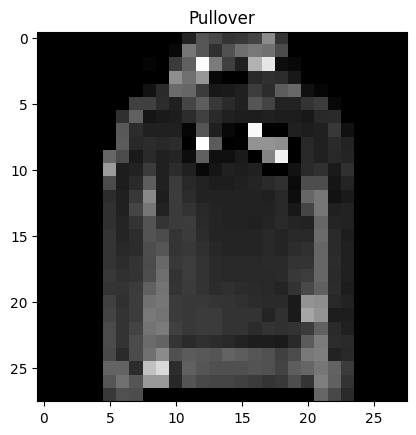

In [108]:
import matplotlib.pyplot as plt
plt.imshow(test_samples[0].squeeze(dim=0), cmap="gray")
plt.title(id_to_class[test_labels[0]])

In [109]:
pred_probs = make_preds(model = model_3,
                             data= test_samples)
pred_probs.shape

torch.Size([9, 10])

### convert prediction probablity to labels

In [110]:
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([2, 4, 4, 3, 2, 2, 0, 1, 1])

### visualize

(-0.5, 27.5, 27.5, -0.5)

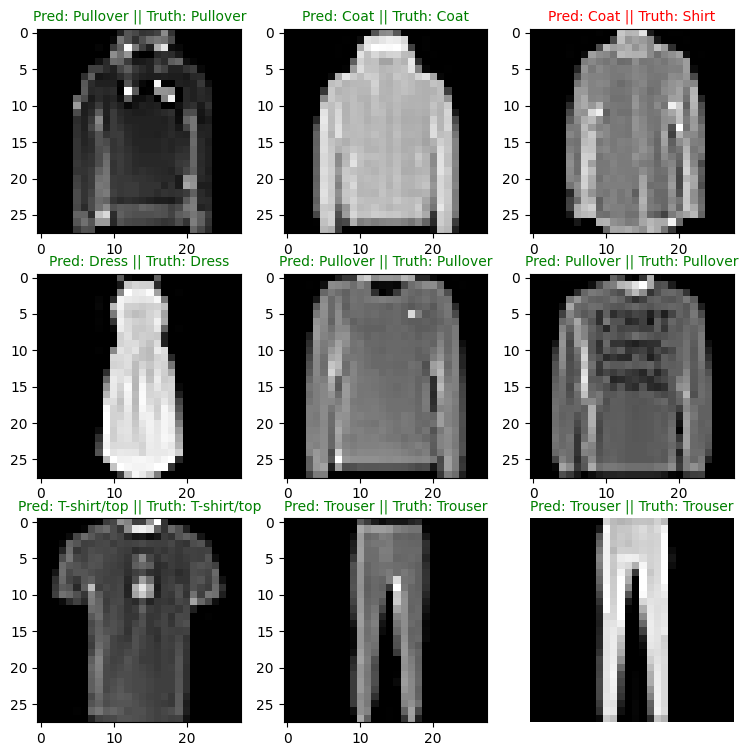

In [111]:
plt.figure(figsize=(9,9))
nrows =3
ncols=3

for i, sample in enumerate(test_samples):
    
    plt.subplot(nrows, ncols, i+1)
    
    plt.imshow(sample.squeeze(), cmap="gray")
    pred_classes[i]
    
    pred_label = id_to_class[pred_classes[i].item()]
    
    truth_label = id_to_class[test_labels[i]]
    
    title_text = f"Pred: {pred_label} || Truth: {truth_label}"
    
    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c="g")
    else:
        plt.title(title_text, fontsize=10, c="r")
plt.axis(False)

### confusion matrix for further evaluation

In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
conf_mat = ConfusionMatrix(num_classes= len(class_names))
confmat_tensor = conf_mat(preds = pred_classes)

In [114]:
from tqdm.auto import tqdm

y_preds = []
model_3.eval()
with torch.inference_mode():
    for X,y in tqdm(test_dataloader, desc ="mAking predictions...."):
        
        X,y = X.to(device), y.to(device)
        
        y_logits = model_3(X)
        y_pred = torch.softmax(y_logits.squeeze(), dim=0).argmax(dim=1)
        
        y_preds.append(y_pred.cpu())

y_pred_tensor = torch.cat(y_preds)
y_pred_tensor
len(y_pred_tensor)

mAking predictions....: 100%|███████████████████████████████| 313/313 [00:00<00:00, 424.81it/s]


10000